<a href="https://colab.research.google.com/github/berkalptnc/proje/blob/main/project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
# Pkgs loading
import pandas as pd
import os
import librosa
import numpy as np
from tqdm import tqdm

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [4]:
audio_dataset_path='/content/drive/MyDrive/Proje/UrbanSound8K/UrbanSound8K/audio'
metadata=pd.read_csv('/content/drive/MyDrive/Proje/UrbanSound8K/UrbanSound8K/metadata/UrbanSound8K.csv')
metadata.head()

,slice_file_name,fsID,start,end,salience,fold,classID,class
0,100032-3-0-0.wav,100032,0.0,0.317551,1,5,3,dog_bark
1,100263-2-0-117.wav,100263,58.5,62.500000,1,5,2,children_playing
2,100263-2-0-121.wav,100263,60.5,64.500000,1,5,2,children_playing
3,100263-2-0-126.wav,100263,63.0,67.000000,1,5,2,children_playing
4,100263-2-0-137.wav,100263,68.5,72.500000,1,5,2,children_playing


In [5]:
# Dataset Balancing/Imbalancing Check
metadata['class'].value_counts()

dog_bark            1000
children_playing    1000
air_conditioner     1000
street_music        1000
engine_idling       1000
jackhammer          1000
drilling            1000
siren                929
car_horn             429
gun_shot             374
Name: class, dtype: int64

In [6]:
# Extracting MFCC's For every audio file
def features_extractor(file_name):
    audio, sample_rate = librosa.load(file_name, res_type='kaiser_fast') 
    mfccs_features = librosa.feature.mfcc(y=audio, sr=sample_rate, n_mfcc=40)
    mfccs_scaled_features = np.mean(mfccs_features.T,axis=0)
    
    return mfccs_scaled_features

In [7]:
# Features extraction from all audio files (MFCC)
extracted_features=[]
for index_num,row in tqdm(metadata.iterrows()):
    file_name = os.path.join(os.path.abspath(audio_dataset_path),'fold'+str(row["fold"])+'/',str(row["slice_file_name"]))
    final_class_labels=row["class"]
    data=features_extractor(file_name)
    extracted_features.append([data,final_class_labels])

3555it [55:06,  1.13it/s]/usr/local/lib/python3.7/dist-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=1323
  n_fft, y.shape[-1]
8326it [2:06:42,  1.50it/s]/usr/local/lib/python3.7/dist-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=1103
  n_fft, y.shape[-1]
8329it [2:06:43,  1.62it/s]/usr/local/lib/python3.7/dist-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=1523
  n_fft, y.shape[-1]
8732it [2:12:23,  1.10it/s]


In [8]:
# Converting extracted_features to Pandas dataframe
extracted_features_df=pd.DataFrame(extracted_features,columns=['feature','class'])
extracted_features_df.head()

,feature,class
0,"[-214.95764, 70.502464, -130.70279, -53.116936...",dog_bark
1,"[-423.7311, 109.2299, -52.872597, 60.827538, 0...",children_playing
2,"[-458.52844, 121.35432, -46.535675, 51.969467,...",children_playing
3,"[-413.63254, 101.61351, -35.43868, 53.047146, ...",children_playing
4,"[-446.38693, 113.68634, -52.4572, 60.349724, 2...",children_playing


In [9]:
# Data Frame Saving
extracted_features_df.to_csv("UrbanSound8K_DF.csv")

In [10]:
# Data Splitting
X=np.array(extracted_features_df['feature'].tolist())
y=np.array(extracted_features_df['class'].tolist())

In [11]:
X.shape

(8732, 40)

In [12]:
y

array(['dog_bark', 'children_playing', 'children_playing', ...,
       'car_horn', 'car_horn', 'car_horn'], dtype='<U16')

In [13]:
# Label Encoding
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import LabelEncoder
labelencoder=LabelEncoder()
y=to_categorical(labelencoder.fit_transform(y))

In [14]:
y

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 1., ..., 0., 0., 0.],
       [0., 0., 1., ..., 0., 0., 0.],
       ...,
       [0., 1., 0., ..., 0., 0., 0.],
       [0., 1., 0., ..., 0., 0., 0.],
       [0., 1., 0., ..., 0., 0., 0.]], dtype=float32)

In [15]:
# Training Testing Sets
from sklearn.model_selection import train_test_split
X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.2,random_state=0)

In [16]:
X_train

array([[-1.3082390e+02,  1.1256225e+02, -2.2600878e+01, ...,
         3.2528090e+00, -1.3692100e+00,  2.7386472e+00],
       [-1.3446434e+01,  9.1048195e+01, -7.8661475e+00, ...,
        -3.2665925e+00, -5.2884049e+00, -1.5532947e+00],
       [-4.9575279e+01,  2.3543632e-01, -2.0504959e+01, ...,
         2.8775635e+00, -1.5828822e+00,  3.5109408e+00],
       ...,
       [-4.2677444e+02,  9.2583252e+01,  3.3174915e+00, ...,
         7.9330575e-01,  7.1890563e-01,  7.1397936e-01],
       [-1.4541722e+02,  1.3619025e+02, -3.3450352e+01, ...,
         1.4591718e+00, -1.9928970e+00, -8.9318532e-01],
       [-4.2099823e+02,  2.1074756e+02,  3.5814040e+00, ...,
        -5.4054899e+00, -3.3959770e+00, -1.5590971e+00]], dtype=float32)

In [17]:
X_train.shape

(6985, 40)

In [19]:
X_test.shape

(1747, 40)

In [20]:
y_train.shape

(6985, 10)

In [21]:
y_test.shape

(1747, 10)

In [22]:
import tensorflow as tf
print(tf.__version__)

2.8.2


In [23]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense,Dropout,Activation
from sklearn import metrics

In [24]:
# No of classes
num_labels=y.shape[1]
print(num_labels)

10


In [25]:
model=Sequential()
#first layer
model.add(Dense(1600,input_shape=(40,)))
model.add(Activation('relu'))
model.add(Dropout(0.5))
#second layer
model.add(Dense(800))
model.add(Activation('relu'))
model.add(Dropout(0.5))
#third layer
model.add(Dense(400))
model.add(Activation('relu'))
model.add(Dropout(0.5))

#final layer
model.add(Dense(num_labels))
model.add(Activation('softmax'))

In [26]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 1600)              65600     
                                                                 
 activation (Activation)     (None, 1600)              0         
                                                                 
 dropout (Dropout)           (None, 1600)              0         
                                                                 
 dense_1 (Dense)             (None, 800)               1280800   
                                                                 
 activation_1 (Activation)   (None, 800)               0         
                                                                 
 dropout_1 (Dropout)         (None, 800)               0         
                                                                 
 dense_2 (Dense)             (None, 400)               3

In [27]:
model.compile(loss='categorical_crossentropy',metrics=['accuracy'],optimizer='adam')

In [28]:
# Model training
from tensorflow.keras.callbacks import ModelCheckpoint
from datetime import datetime 

In [45]:
num_epochs = 500
num_batch_size = 128

checkpointer = ModelCheckpoint(filepath='saved_models/audio_classification.h5', verbose=1, save_best_only=True)
start = datetime.now()

results = model.fit(X_train, y_train, batch_size=num_batch_size, epochs=num_epochs, validation_data=(X_test, y_test), callbacks=[checkpointer], verbose=1)


duration = datetime.now() - start
print("Training completed in time: ", duration)

Epoch 1/500
55/55 [==============================] - ETA: 0s - loss: 0.1129 - accuracy: 0.9711
Epoch 1: val_loss improved from inf to 0.26749, saving model to saved_models/audio_classification.h5
55/55 [==============================] - 1s 11ms/step - loss: 0.1129 - accuracy: 0.9711 - val_loss: 0.2675 - val_accuracy: 0.9439
Epoch 2/500
52/55 [===========================>..] - ETA: 0s - loss: 0.1100 - accuracy: 0.9707
Epoch 2: val_loss improved from 0.26749 to 0.26522, saving model to saved_models/audio_classification.h5
55/55 [==============================] - 1s 14ms/step - loss: 0.1099 - accuracy: 0.9705 - val_loss: 0.2652 - val_accuracy: 0.9468
Epoch 3/500
43/55 [======================>.......] - ETA: 0s - loss: 0.1273 - accuracy: 0.9695
Epoch 3: val_loss did not improve from 0.26522
55/55 [==============================] - 0s 5ms/step - loss: 0.1166 - accuracy: 0.9704 - val_loss: 0.2784 - val_accuracy: 0.9450
Epoch 4/500
44/55 [=======================>......] - ETA: 0s - loss: 0.13

In [46]:
test_accuracy=model.evaluate(X_test,y_test,verbose=0)
print(test_accuracy[1])

0.949055552482605


In [47]:
#https://freewavesamples.com/dog-bark download the sample
filename="/content/drive/MyDrive/Proje/Dog-Bark.wav"
audio, sample_rate = librosa.load(filename, res_type='kaiser_fast') 
mfccs_features = librosa.feature.mfcc(y=audio, sr=sample_rate, n_mfcc=40)
mfccs_scaled_features = np.mean(mfccs_features.T,axis=0)

In [48]:
mfccs_scaled_features.shape

(40,)

In [49]:
mfccs_scaled_features=mfccs_scaled_features.reshape(1,-1)
print(mfccs_scaled_features.shape)
predicted_label = np.argmax(model.predict(mfccs_scaled_features), axis=-1)
print('Predicted Label:',predicted_label)
prediction_class = labelencoder.inverse_transform(predicted_label) 
prediction_class[0]

(1, 40)
Predicted Label: [3]


'dog_bark'

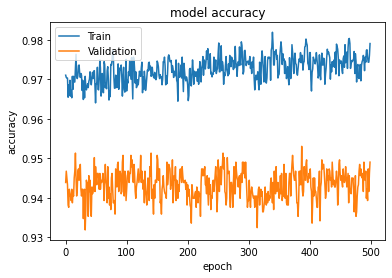

In [53]:
import matplotlib.pyplot as plt

# summarize history for accuracy
plt.plot(results.history['accuracy'])
plt.plot(results.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

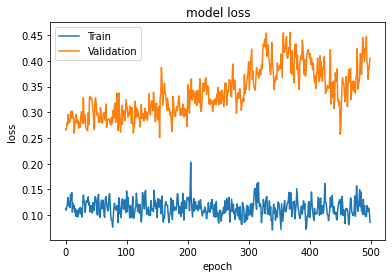

In [54]:
# summarize history for loss
plt.plot(results.history['loss'])
plt.plot(results.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()